In [ ]:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#creating folders
import os
dataset_dir = '/content/drive/My Drive/Dataset/'
raw_img_dir   = dataset_dir+'raw_img_1_MOV/'
raw_lbl_dir   = dataset_dir+'raw_lbl_1_MOV'

classes_file_path= dataset_dir+'classes.txt'
os.makedirs(raw_img_dir, exist_ok=True)
os.makedirs(raw_lbl_dir, exist_ok=True)


In [ ]:
# access the video file where is located in google drive

print(classes_file_path)

/content/drive/My Drive/Dataset/classes.txt


classes in classes.txt

In [ ]:

Classes=list()
Classes.append("Dinner Table") #0
Classes.append("Tea Glass") #1
Classes.append("Spoon Box")#2
Classes.append("Person")#3
Classes.append("Tea Jar")#4
Classes.append("Human Hand") #5

index=0;
with open(classes_file_path, 'w') as writefile:
  while index<6:
    line=Classes[index]+"\n";
    writefile.write(line);
    index+=1;


In [ ]:
  import os
  import cv2

  video_path = '/content/drive/My Drive/Video/1.MOV'
  cap = cv2.VideoCapture(video_path)

  imgs_dir = raw_img_dir
  lbls_dir = raw_lbl_dir
  frame_count = 0

  # first video has fixed set of objects (table,tea glass, spoon box)
  # so for every frame add lables and boxes for these objects
  while True:
       ret, frame = cap.read()
       if not ret:
           break

       H, W = frame.shape[:2]

       print(height, width )

       # Save frame
       image_filename = os.path.join(imgs_dir, f'frame_{frame_count:05d}.jpg')  # image file
       lbl_filename   = os.path.join(lbls_dir, f'frame_{frame_count:05d}.txt')  # label file according YOLO TXT format
       cv2.imwrite(image_filename, frame)
       with open(lbl_filename, 'w') as writefile:
          ## class_id, center_x,center_y,with,hieght  normalized values
          writefile.write("0 0.58 0.5  0.85  0.7\n")
          writefile.write("1 0.32 0.19  0.08  0.12\n")
          writefile.write("1 0.32 0.76  0.08  0.12\n")
          writefile.write("2 0.165 0.3  0.07  0.28\n")

       frame_count += 1
       print(f"Processed {frame_count} frames")




  cap.release()

In [ ]:
# moving tea jar and hand
frame_count=102
while frame_count<=178 :
   lbl_filename   = os.path.join(lbls_dir, f'frame_{frame_count:05d}.txt')  # label file according YOLO TXT format
   with open(lbl_filename, 'w') as writefile:
          ## class_id, center_x,center_y,with,hieght  normalized values
          writefile.write("0 0.58 0.5  0.85  0.7\n")
          writefile.write("1 0.32 0.19  0.08  0.12\n")
          writefile.write("1 0.32 0.76  0.08  0.12\n")
          writefile.write("2 0.165 0.3  0.07  0.28\n")
          x=0.035+0.022*frame_count
          if x> 0.52:
            x=0.52
          y=0.16+0.04*frame_count
          if y > 0.4:
              y=0.4
          line="4 "+str(x)+" "+str(y)+" 0.067  0.16\n";
          writefile.write(line)
          if frame_count>112 :
            if frame_count<144:
              writefile.write("5 0.15 0.26 0.14  0.08\n")
            elif frame_count <156:
               writefile.write("5 0.15 0.2 0.14  0.08\n")

   frame_count+=1;

Splitting Data into Train/Val/Test
70%  training  15% valid  15% test

In [ ]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split


images_dir = raw_img_dir
labels_dir = raw_lbl_dir
output_dir = dataset_dir

# Create output directories
for folder in ['train', 'val', 'test']:
    os.makedirs(os.path.join(output_dir, 'images', folder), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels', folder), exist_ok=True)


In [ ]:
# Get list of image files (assuming .jpg, modify if different)
image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

# Split into train+temp (80%), then split temp into val and test (50% each)
train_files, temp_files = train_test_split(image_files, test_size=0.2, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

In [ ]:

def copy_files(files, split_name):

    for file in files:
        # Copy image
        shutil.copy(
            os.path.join(images_dir, file),
            os.path.join(output_dir, 'images', split_name, file)
        )

        # Copy corresponding label file (assuming .txt format)
        label_file = os.path.splitext(file)[0] + '.txt'
        shutil.copy(
            os.path.join(labels_dir, label_file),
            os.path.join(output_dir, 'labels', split_name, label_file)
        )

# Copy files to their respective directories
copy_files(train_files, 'train')
copy_files(val_files, 'val')
copy_files(test_files, 'test')

# Print statistics
print(f"Total images: {len(image_files)}")
print(f"Train: {len(train_files)} ({len(train_files)/len(image_files):.1%})")
print(f"Validation: {len(val_files)} ({len(val_files)/len(image_files):.1%})")
print(f"Test: {len(test_files)} ({len(test_files)/len(image_files):.1%})")

Total images: 179
Train: 143 (79.9%)
Validation: 18 (10.1%)
Test: 18 (10.1%)


Building YOLO11

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 841.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from ultralytics import YOLO

# Load a pretrained YOLO11n model
model = YOLO("yolo11n.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 15.8MB/s]


First Training for 40 Epoch

In [ ]:
# Train the model
results = model.train(
    data= dataset_dir+'Dinner_dataset.yaml',
    epochs=40,
    imgsz=640,
    batch=16,
    device='cpu',
    val=True,       # Enable validation
    plots=True,    # Generate metric plots
    save_json=True  # Save metrics to JSON
)


New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Dataset/Dinner_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train19, nbs=64, nms=False, opse

train: Scanning /content/drive/My Drive/Dataset/labels/train.cache... 23 images, 120 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 257.4±43.1 MB/s, size: 2059.8 KB)



val: Scanning /content/drive/My Drive/Dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]


Plotting labels to runs/detect/train19/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train19
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40         0G      0.392      1.471      0.866         34        640: 100%|██████████| 9/9 [02:11<00:00, 14.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.45s/it]

                   all         22        106      0.993      0.331      0.462      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40         0G     0.3596      1.487     0.8643         26        640: 100%|██████████| 9/9 [02:08<00:00, 14.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]

                   all         22        106          1      0.315      0.429      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40         0G     0.3528      1.253     0.8304         27        640: 100%|██████████| 9/9 [02:03<00:00, 13.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]

                   all         22        106      0.983      0.284      0.414      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         0G     0.3784      1.362     0.8722         18        640: 100%|██████████| 9/9 [02:00<00:00, 13.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

                   all         22        106      0.973      0.334      0.469      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         0G     0.3657       1.43     0.8442         22        640: 100%|██████████| 9/9 [02:02<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]

                   all         22        106          1      0.393      0.487      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         0G     0.3555      1.084     0.8254         27        640: 100%|██████████| 9/9 [02:04<00:00, 13.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:06<00:00,  6.20s/it]

                   all         22        106      0.981      0.338      0.424      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         0G     0.4282      1.674     0.8662         31        640: 100%|██████████| 9/9 [02:05<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]

                   all         22        106      0.951      0.232      0.292      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         0G     0.3908      1.284     0.8602         17        640: 100%|██████████| 9/9 [02:05<00:00, 13.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]

                   all         22        106          1     0.0799      0.209      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         0G     0.3947       1.28     0.8585         42        640: 100%|██████████| 9/9 [01:59<00:00, 13.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

                   all         22        106          1     0.0795      0.222      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         0G     0.3908      1.355      0.849          8        640: 100%|██████████| 9/9 [02:00<00:00, 13.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.74s/it]

                   all         22        106      0.979      0.183      0.285      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         0G     0.3736      1.275     0.8709         14        640: 100%|██████████| 9/9 [02:00<00:00, 13.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.85s/it]

                   all         22        106      0.945      0.133      0.327      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         0G     0.3836      1.662     0.8506         16        640: 100%|██████████| 9/9 [01:58<00:00, 13.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.76s/it]

                   all         22        106      0.961      0.274      0.423      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         0G     0.3663      1.304     0.8647         14        640: 100%|██████████| 9/9 [02:00<00:00, 13.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

                   all         22        106      0.957      0.271       0.41      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         0G     0.3462      1.201     0.8364         18        640: 100%|██████████| 9/9 [02:06<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]

                   all         22        106          1       0.26      0.382      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         0G      0.368      1.287     0.8468         10        640: 100%|██████████| 9/9 [02:01<00:00, 13.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.49s/it]

                   all         22        106      0.968      0.237      0.351      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         0G     0.4013      1.186     0.8805         11        640: 100%|██████████| 9/9 [01:58<00:00, 13.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.87s/it]

                   all         22        106      0.931      0.226      0.383      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40         0G     0.4041     0.9983     0.8769         20        640: 100%|██████████| 9/9 [02:05<00:00, 13.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

                   all         22        106      0.908      0.226      0.373      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40         0G     0.3653      1.074     0.8432         22        640: 100%|██████████| 9/9 [02:03<00:00, 13.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

                   all         22        106      0.968      0.209      0.367      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40         0G     0.3927      1.255     0.8594         25        640: 100%|██████████| 9/9 [02:00<00:00, 13.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.96s/it]

                   all         22        106      0.975      0.263      0.465      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40         0G        0.4      1.056     0.8284         24        640: 100%|██████████| 9/9 [01:59<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.77s/it]

                   all         22        106      0.916      0.372      0.491       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40         0G     0.3519      1.126     0.8512         25        640: 100%|██████████| 9/9 [02:00<00:00, 13.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

                   all         22        106      0.986      0.324        0.5       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40         0G      0.343     0.9656     0.8404         21        640: 100%|██████████| 9/9 [02:02<00:00, 13.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.19s/it]

                   all         22        106      0.942      0.303      0.486       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40         0G     0.3773      1.199     0.8556         19        640: 100%|██████████| 9/9 [01:57<00:00, 13.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

                   all         22        106      0.916      0.222      0.438       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40         0G     0.3677      1.518     0.8357         25        640: 100%|██████████| 9/9 [01:59<00:00, 13.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

                   all         22        106      0.679      0.173       0.36      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40         0G     0.3592      1.119     0.8303         14        640: 100%|██████████| 9/9 [02:00<00:00, 13.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

                   all         22        106      0.767      0.198       0.35      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40         0G     0.3075      1.131     0.8392         19        640: 100%|██████████| 9/9 [02:01<00:00, 13.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.63s/it]

                   all         22        106      0.768      0.195      0.352      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40         0G     0.3294      1.315     0.8744         20        640: 100%|██████████| 9/9 [01:59<00:00, 13.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.60s/it]

                   all         22        106      0.967       0.18      0.388      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40         0G     0.2851     0.9242     0.8101         26        640: 100%|██████████| 9/9 [01:59<00:00, 13.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.67s/it]

                   all         22        106      0.707      0.202      0.446      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40         0G     0.3008     0.9125     0.8455         21        640: 100%|██████████| 9/9 [02:00<00:00, 13.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.68s/it]

                   all         22        106      0.726      0.264      0.462      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40         0G     0.3194     0.9876     0.8311         25        640: 100%|██████████| 9/9 [02:00<00:00, 13.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]

                   all         22        106      0.718      0.208      0.444       0.42


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40         0G     0.3157      11.51     0.7226         16        640: 100%|██████████| 9/9 [02:00<00:00, 13.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.66s/it]

                   all         22        106      0.776      0.196       0.42      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40         0G     0.3242      6.763     0.7059          8        640: 100%|██████████| 9/9 [02:00<00:00, 13.38s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.69s/it]

                   all         22        106      0.793      0.163      0.354      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40         0G     0.3025      1.471     0.8167          8        640: 100%|██████████| 9/9 [02:02<00:00, 13.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.70s/it]

                   all         22        106      0.768      0.149      0.357      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40         0G     0.2838      5.955     0.7336          4        640: 100%|██████████| 9/9 [02:02<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.33s/it]

                   all         22        106      0.768      0.149      0.363       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40         0G     0.2744      1.144     0.8035          8        640: 100%|██████████| 9/9 [02:03<00:00, 13.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.54s/it]

                   all         22        106      0.768       0.15      0.364      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40         0G     0.2298      5.193     0.6753          0        640: 100%|██████████| 9/9 [02:02<00:00, 13.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

                   all         22        106      0.768       0.15      0.374      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40         0G     0.2499      6.458      0.707          0        640: 100%|██████████| 9/9 [02:04<00:00, 13.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.65s/it]

                   all         22        106      0.768       0.15      0.395      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40         0G     0.2774      1.321     0.8122         16        640: 100%|██████████| 9/9 [02:05<00:00, 13.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.85s/it]

                   all         22        106        0.8      0.158      0.419      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40         0G     0.2859      1.064      0.805         12        640: 100%|██████████| 9/9 [02:02<00:00, 13.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.26s/it]

                   all         22        106        0.8      0.158      0.417      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40         0G     0.2742      1.425     0.8198          8        640: 100%|██████████| 9/9 [02:00<00:00, 13.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.01s/it]

                   all         22        106      0.768       0.15       0.42      0.375



40 epochs completed in 1.416 hours.
Optimizer stripped from runs/detect/train19/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train19/weights/best.pt, 5.4MB

Validating runs/detect/train19/weights/best.pt...
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]


                   all         22        106      0.986      0.324      0.501       0.46
          Dinner Table         22         22          1       0.51      0.859      0.817
             Tea Glass         22         44          1       0.52      0.952      0.926
             Spoon Box         22         22      0.932      0.591      0.693      0.556
               Tea Jar          9          9          1          0          0          0
            Human Hand          9          9          1          0          0          0
Speed: 1.4ms preprocess, 120.0ms inference, 0.0ms loss, 0.7ms postprocess per image
Saving runs/detect/train19/predictions.json...
Results saved to runs/detect/train19


In [ ]:

import pandas as pd
from google.colab import files
from IPython.display import display


# Read and display CSV
results_df = pd.read_csv('/content/runs/detect/train19/results.csv')  # or next(iter(uploaded.keys()))
display(results_df.head())  # Shows first 5 rows with nice formatting

# For full table with scroll
display(results_df.style.set_properties(**{'text-align': 'center'}).set_table_styles(   [dict(selector='th', props=[('text-align', 'center')])]))

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,137.196,0.39202,1.47109,0.86600,0.99285,0.33054,0.46159,0.44179,0.68476,1.94944,1.09687,0.000080,0.000080,0.000080
1,2,270.623,0.35955,1.48669,0.86429,1.00000,0.31493,0.42869,0.40872,0.73786,2.22974,1.10985,0.000166,0.000166,0.000166
2,3,399.074,0.35277,1.25291,0.83036,0.98254,0.28377,0.41386,0.40061,0.71506,2.20789,1.10003,0.000247,0.000247,0.000247
3,4,525.178,0.37845,1.36198,0.87225,0.97260,0.33405,0.46883,0.43920,0.77119,1.91359,1.13296,0.000324,0.000324,0.000324
4,5,652.625,0.36572,1.42988,0.84420,0.99961,0.39275,0.48685,0.46059,0.74114,1.74915,1.10028,0.000396,0.000396,0.000396


,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,137.196000,0.392020,1.471090,0.866000,0.992850,0.330540,0.461590,0.441790,0.684760,1.949440,1.096870,0.000080,0.000080,0.000080
1,2,270.623000,0.359550,1.486690,0.864290,1.000000,0.314930,0.428690,0.408720,0.737860,2.229740,1.109850,0.000166,0.000166,0.000166
2,3,399.074000,0.352770,1.252910,0.830360,0.982540,0.283770,0.413860,0.400610,0.715060,2.207890,1.100030,0.000247,0.000247,0.000247
3,4,525.178000,0.378450,1.361980,0.872250,0.972600,0.334050,0.468830,0.439200,0.771190,1.913590,1.132960,0.000324,0.000324,0.000324
4,5,652.625000,0.365720,1.429880,0.844200,0.999610,0.392750,0.486850,0.460590,0.741140,1.749150,1.100280,0.000396,0.000396,0.000396
5,6,783.761000,0.355530,1.084070,0.825380,0.981220,0.337770,0.423650,0.395420,0.774100,1.996590,1.101030,0.000464,0.000464,0.000464
6,7,914.303000,0.428160,1.674430,0.866160,0.950750,0.232200,0.292140,0.258700,0.790700,2.762800,1.142810,0.000528,0.000528,0.000528
7,8,1044.940000,0.390820,1.283810,0.860160,1.000000,0.079900,0.208910,0.163900,0.875030,3.688340,1.216510,0.000587,0.000587,0.000587
8,9,1169.270000,0.394670,1.280090,0.858550,1.000000,0.079470,0.222130,0.191760,0.875370,3.631640,1.230230,0.000642,0.000642,0.000642
9,10,1295.280000,0.390800,1.354690,0.848950,0.978690,0.182690,0.285210,0.262480,0.849300,3.215250,1.202590,0.000692,0.000692,0.000692


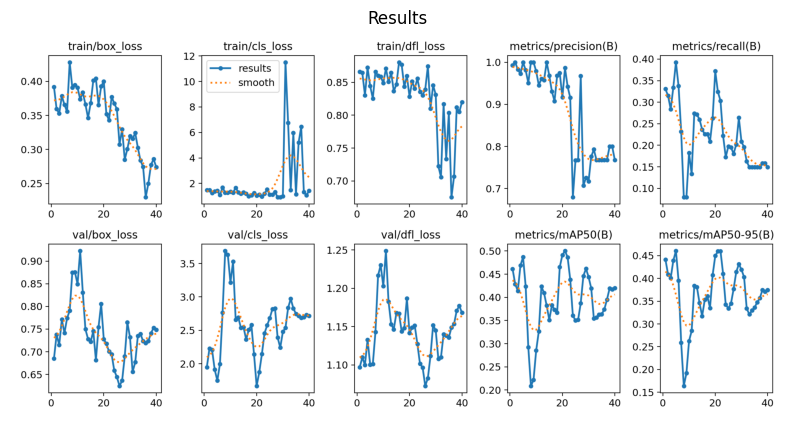

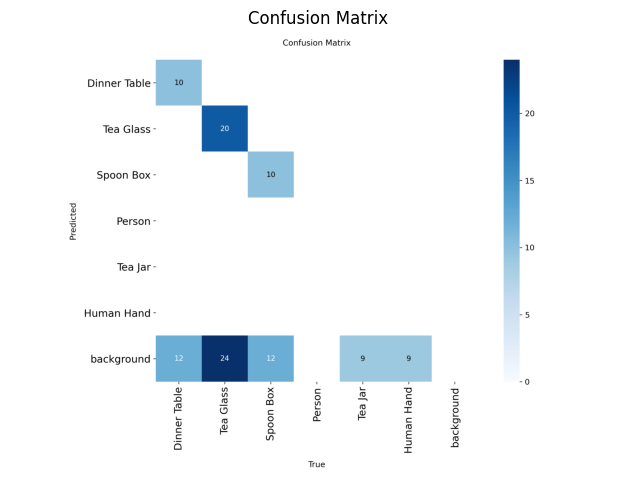

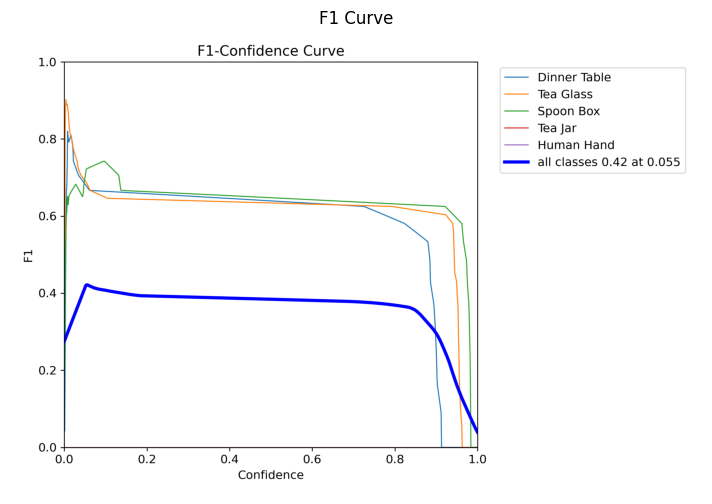

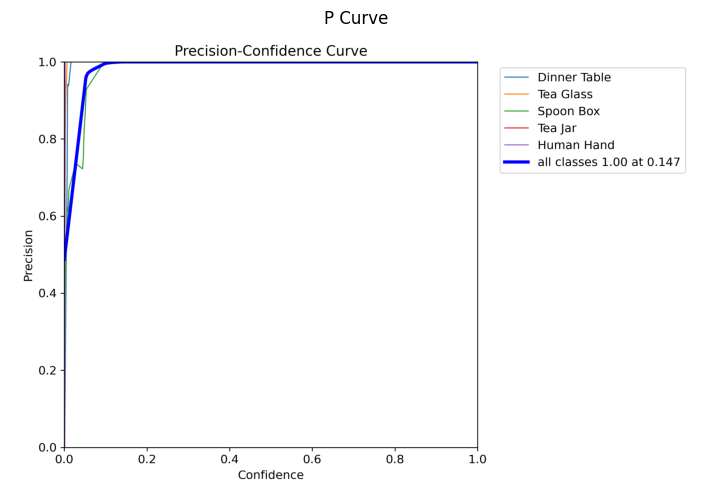

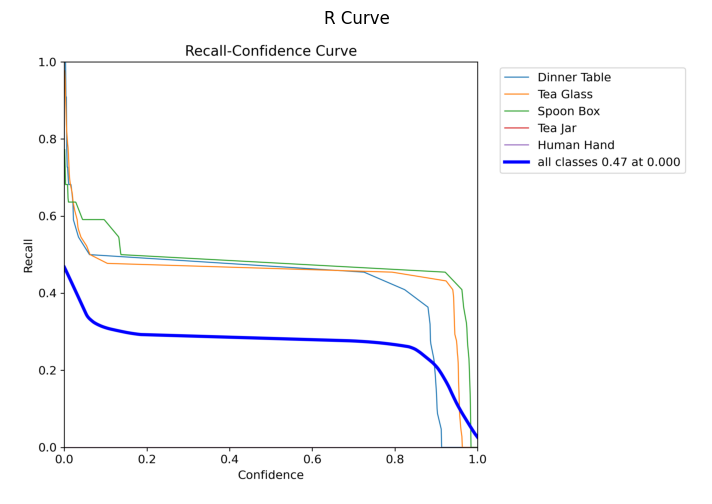

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
res_dir='/content/runs/detect/train19/'
# List of YOLO result images you might have
result_images = [
    'results.png',          # Training metrics plot
    'confusion_matrix.png', # Confusion matrix
    'F1_curve.png',        # F1-score curve
    'P_curve.png',         # Precision curve
    'R_curve.png'          # Recall curve
]

# Display each image that exists
for img_file in result_images:
    try:
        plt.figure(figsize=(10, 6))
        img = mpimg.imread(res_dir+img_file)
        plt.imshow(img)
        plt.title(img_file.split('.')[0].replace('_', ' ').title())
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"Note: {img_file} not found - skipping")

Second Training for 60 Epoch

In [ ]:
# Train the model
results = model.train(
    data= dataset_dir+'Dinner_dataset.yaml',
    epochs=40,
    imgsz=640,
    batch=16,
    device='cpu',
    val=True,       # Enable validation
    plots=True,    # Generate metric plots
    save_json=True  # Save metrics to JSON
)


New https://pypi.org/project/ultralytics/8.3.159 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.158 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/My Drive/Dataset/Dinner_dataset.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train192, nbs=64, nms=False, ops

train: Scanning /content/drive/My Drive/Dataset/labels/train.cache... 23 images, 120 backgrounds, 0 corrupt: 100%|██████████| 143/143 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.6±0.1 ms, read: 287.3±84.6 MB/s, size: 2059.8 KB)



val: Scanning /content/drive/My Drive/Dataset/labels/val.cache... 22 images, 0 backgrounds, 0 corrupt: 100%|██████████| 22/22 [00:00<?, ?it/s]

Plotting labels to runs/detect/train192/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train192
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40         0G     0.3424      1.005     0.8552         34        640: 100%|██████████| 9/9 [02:15<00:00, 15.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.81s/it]

                   all         22        106      0.968       0.15      0.426      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40         0G     0.3346      1.013     0.8666         26        640: 100%|██████████| 9/9 [01:57<00:00, 13.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.73s/it]

                   all         22        106      0.768      0.149      0.375      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40         0G      0.312      0.858       0.82         27        640: 100%|██████████| 9/9 [01:59<00:00, 13.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.77s/it]

                   all         22        106        0.8      0.158      0.397      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         0G     0.3384     0.9498     0.8597         18        640: 100%|██████████| 9/9 [01:57<00:00, 13.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.72s/it]

                   all         22        106       0.78      0.286      0.375      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         0G     0.3221     0.9772     0.8262         16        640:  89%|████████▉ | 8/9 [01:46<00:13, 13.46s/it]